--- Starting Main Calculation (3-Model SVP Comparison) ---
  Processing Ts = 280.0 K...
  Processing Ts = 290.0 K...
  Processing Ts = 300.0 K...
  Processing Ts = 310.0 K...
  Processing Ts = 320.0 K...

--- Calculation Finished in 36.00 seconds ---

--- 5. Finding peak warming T_s at each pressure level ---
Peak finding done in 0.0s
--- Generating Figure C1 (2-Panel) ---


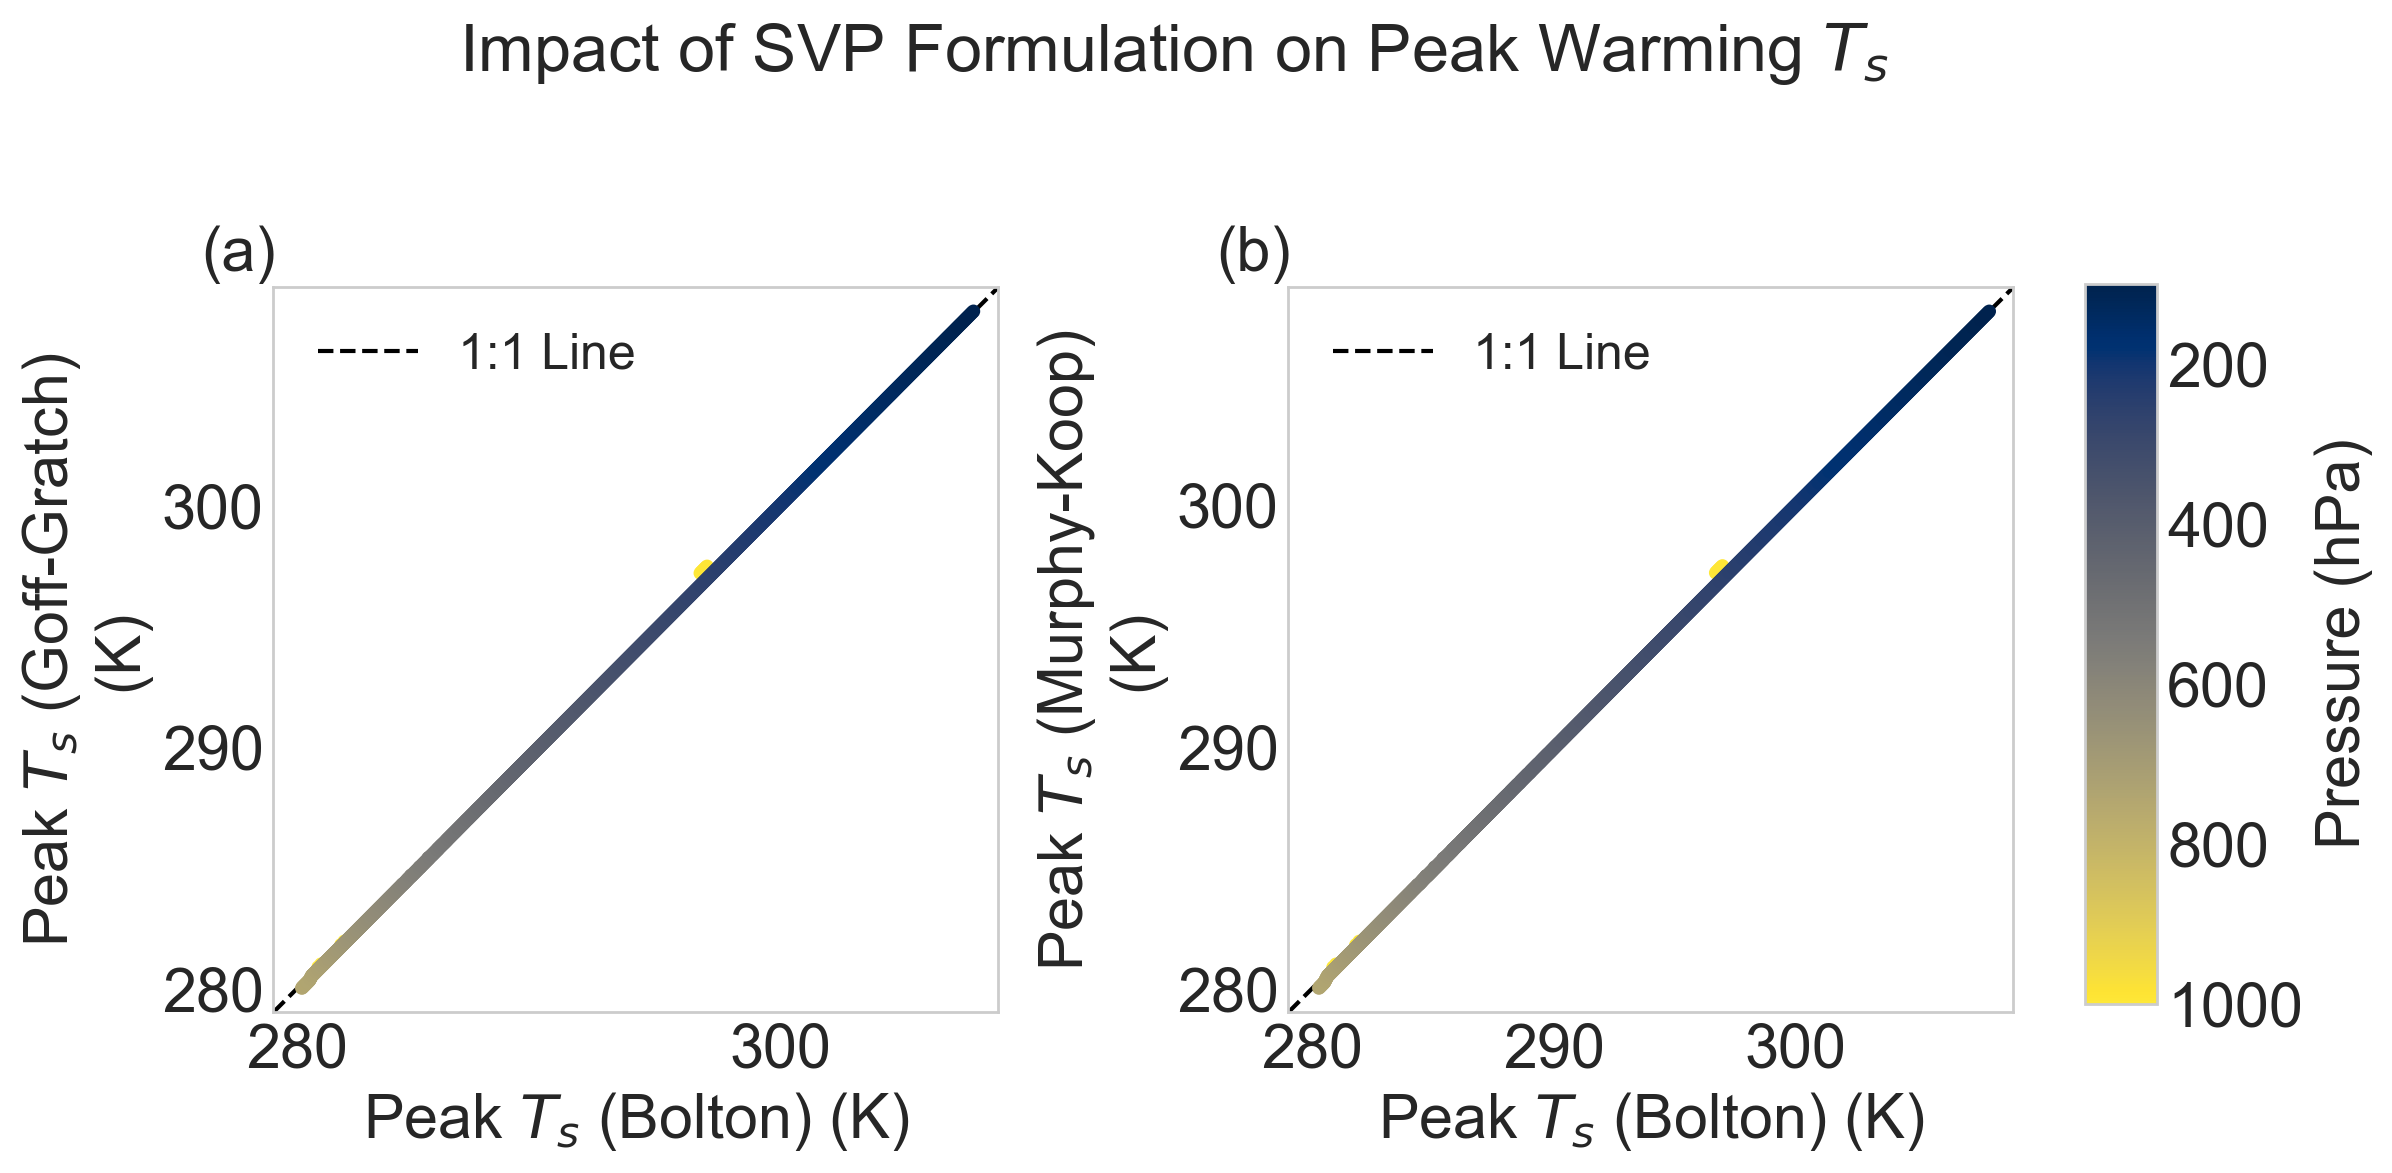

Figure C1 saved as fig-c1.png

Script finished.


In [1]:
# ==============================================================================
# SCRIPT TO CALCULATE AND PLOT FIGURE C1 (SVP Sensitivity)
#
# This script quantifies the role of the saturation vapor pressure (SVP)
# formulation on the non-monotonic warming peak.
#
# It performs the following actions:
# 1. Defines three SVP formulations:
#    - Bolton (1980)
#    - Goff-Gratch (1946)
#    - Murphy and Koop (2005)
# 2. Implements generic thermodynamic functions (qs, Tv, MSE) and a
#    generic profile calculator that accept an SVP function as an argument.
# 3. Runs the profile calculation for all three SVP models over a DENSE
#    grid of surface temperatures (Ts) and for a perturbed state (Ts + 4K).
# 4. Stores warming (Delta T) in three 2D grids: DeltaT(p, Ts) for
#    each model.
# 5. Implements robust peak-finding (from Fig. 4) to find the Ts of
#    maximum warming at each pressure level for all three models.
# 6. Creates Figure C1, a two-panel plot showing:
#    (a) Scatter: Peak Ts (Bolton) vs. Peak Ts (Goff-Gratch)
#    (b) Scatter: Peak Ts (Bolton) vs. Peak Ts (Murphy-Koop)
# ==============================================================================

%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
import time

# --- Physical Constants (Liquid-Only) ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
Lv = 2.501e6  # Latent heat of vaporization (no fusion)

# ==============================================================================
# --- 1. Saturation Vapor Pressure (SVP) Formulations ---
# ==============================================================================

def saturation_vapor_pressure_bolton(T):
    """
    Calculates SVP (Pa) over liquid water via Bolton (1980).
    """
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_vapor_pressure_gg(T):
    """
    Calculates SVP (hPa) over liquid water via Goff-Gratch (1946).
    Returns value in (Pa).
    """
    # Ensure T is an array for vectorized operations
    T = np.asarray(T)
    
    # Avoid division by zero or log(0) if T is 0
    T_ratio = np.full_like(T, np.nan)
    valid_mask = T > 0
    T_ratio[valid_mask] = 373.16 / T[valid_mask]

    term1 = -7.90298 * (T_ratio - 1.0)
    term2 = 5.02808 * np.log10(T_ratio)
    
    # Use 1.0 / T_ratio to avoid T/373.16
    term3_exponent = 11.344 * (1.0 - (1.0 / T_ratio))
    term3 = -1.3816e-7 * (10**(term3_exponent) - 1.0)
    
    term4_exponent = -3.49149 * (T_ratio - 1.0)
    term4 = 8.1328e-3 * (10**(term4_exponent) - 1.0)
    
    term5 = np.log10(1013.246) # Log10 of standard pressure in hPa
    
    log10_ew = term1 + term2 + term3 + term4 + term5
    ew_hPa = 10**log10_ew
    
    return ew_hPa * 100.0 # Convert to Pa

def saturation_vapor_pressure_mk(T):
    """
    Calculates SVP (Pa) over liquid water via Murphy and Koop (2005).
    Returns value in (Pa).
    """
    # Ensure T is an array for vectorized operations
    T = np.asarray(T)
    
    # Avoid division by zero or log(0) if T is 0
    T_safe = np.maximum(T, 1e-6)
    
    term1 = 54.842763
    term2 = -6763.22 / T_safe
    term3 = -4.21 * np.log(T_safe)
    term4 = 0.000367 * T_safe
    
    tanh_term = np.tanh(0.0415 * (T_safe - 218.8))
    
    bracket_term = (53.878 - 1331.22 / T_safe - 9.44523 * np.log(T_safe) + 0.014025 * T_safe)
    
    ln_ew = term1 + term2 + term3 + term4 + tanh_term * bracket_term
    ew_Pa = np.exp(ln_ew)
    
    return ew_Pa

# ==============================================================================
# --- 2. Generic Thermodynamic Functions ---
# ==============================================================================

def saturation_specific_humidity(p, T, svp_func):
    """Calculates qs (kg/kg) using the provided SVP function."""
    es = svp_func(T)
    es = np.minimum(es, p * 0.99)
    denominator = p - (1.0 - epsilon) * es
    qs = epsilon * es / denominator
    return np.maximum(qs, 1e-9)

def virtual_temperature(T, p, svp_func):
    """Calculates Tv using the provided SVP function."""
    qs = saturation_specific_humidity(p, T, svp_func)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

def calculate_mse(T, p, z, svp_func):
    """Calculates MSE (J/kg) using the provided SVP function."""
    qs = saturation_specific_humidity(p, T, svp_func)
    mse = cpd * T + g * z + Lv * qs
    return mse

# ==============================================================================
# --- 3. Generic Profile Calculation ---
# ==============================================================================

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid, svp_func):
    """
    Calculates T(p) by conserving MSE at each pressure step.
    Uses the provided svp_func for all thermodynamic calculations.
    """
    n_steps = len(p_grid)
    T_profile = np.full(n_steps, np.nan)
    z_profile = np.full(n_steps, np.nan)

    T_profile[0] = T_surf
    z_profile[0] = 0.0
    
    # Calculate conserved MSE using the specified svp_func
    mse_conserved = calculate_mse(T_profile[0], p_grid[0], z_profile[0], svp_func)

    for i in range(n_steps - 1):
        T_curr, p_curr, z_curr = T_profile[i], p_grid[i], z_profile[i]
        p_next = p_grid[i+1]

        if np.isnan(T_curr) or p_curr <= 0: break

        # Calculate Tv and dz using the specified svp_func
        Tv_curr = virtual_temperature(T_curr, p_curr, svp_func)
        alpha_curr = (Rd * Tv_curr) / p_curr
        dz = - (alpha_curr / g) * (p_next - p_curr)
        z_next = z_curr + dz
        
        # Define the residual function, capturing svp_func from its scope
        def mse_residual(T_guess):
            return calculate_mse(T_guess, p_next, z_next, svp_func) - mse_conserved
        
        try:
            bracket = [150.0, T_curr + 5.0]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0: break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1] = sol.root
                z_profile[i+1] = z_next
            else: break
        except (ValueError, RuntimeError): break
            
    return T_profile

# ==============================================================================
# --- 4. Main Calculation Block (Run All 3 Models) ---
# ==============================================================================

print("--- Starting Main Calculation (3-Model SVP Comparison) ---")
start_time = time.time()

# Parameters
T_surf_vals = np.arange(280, 320.1, 0.5) # Dense grid for peak finding
p_surf_pa = 100000.0
p_top_pa = 10000.0
dp_pa = -50.0
p_grid = np.arange(p_surf_pa, p_top_pa + dp_pa, dp_pa)
delta_T_surf = 4.0

n_p = len(p_grid)
n_t = len(T_surf_vals)

# 2D Grids for storing warming: [pressure, T_surf]
warming_grid_bolton = np.full((n_p, n_t), np.nan)
warming_grid_gg = np.full((n_p, n_t), np.nan)
warming_grid_mk = np.full((n_p, n_t), np.nan)

for j, T_s in enumerate(T_surf_vals):
    if j % 20 == 0:
        print(f"  Processing Ts = {T_s:.1f} K...")
    
    # --- 1. Bolton Calculation ---
    T1_b = calculate_profile_with_rootfinder(T_s, p_surf_pa, p_grid, saturation_vapor_pressure_bolton)
    T2_b = calculate_profile_with_rootfinder(T_s + delta_T_surf, p_surf_pa, p_grid, saturation_vapor_pressure_bolton)
    if not np.isnan(T1_b[-1]) and not np.isnan(T2_b[-1]):
        warming_grid_bolton[:, j] = T2_b - T1_b

    # --- 2. Goff-Gratch Calculation ---
    T1_g = calculate_profile_with_rootfinder(T_s, p_surf_pa, p_grid, saturation_vapor_pressure_gg)
    T2_g = calculate_profile_with_rootfinder(T_s + delta_T_surf, p_surf_pa, p_grid, saturation_vapor_pressure_gg)
    if not np.isnan(T1_g[-1]) and not np.isnan(T2_g[-1]):
        warming_grid_gg[:, j] = T2_g - T1_g
        
    # --- 3. Murphy-Koop Calculation ---
    T1_m = calculate_profile_with_rootfinder(T_s, p_surf_pa, p_grid, saturation_vapor_pressure_mk)
    T2_m = calculate_profile_with_rootfinder(T_s + delta_T_surf, p_surf_pa, p_grid, saturation_vapor_pressure_mk)
    if not np.isnan(T1_m[-1]) and not np.isnan(T2_m[-1]):
        warming_grid_mk[:, j] = T2_m - T1_m

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

# ==============================================================================
# --- 5. Peak Finding ---
# ==============================================================================

print("--- 5. Finding peak warming T_s at each pressure level ---")
t_peak_start = time.time()

# --- Calculate gradients w.r.t. T_s ---
dT_s = T_surf_vals[1] - T_surf_vals[0]
grad_warming_bolton = np.gradient(warming_grid_bolton, dT_s, axis=1)
grad_warming_gg = np.gradient(warming_grid_gg, dT_s, axis=1)
grad_warming_mk = np.gradient(warming_grid_mk, dT_s, axis=1)

p_hpa_grid = p_grid / 100.0
peak_Ts_bolton = np.full(n_p, np.nan)
peak_Ts_gg = np.full(n_p, np.nan)
peak_Ts_mk = np.full(n_p, np.nan)

# --- Helper function: find_interpolated_root (from Fig. 4) ---
def find_interpolated_root(y_slice, x_vals, y_slice_for_guess=None, guess_mode='min'):
    """Finds the interpolated root of y_slice."""
    if np.all(np.isnan(y_slice)): return np.nan
    sign_changes = np.where((y_slice[:-1] * y_slice[1:]) < 0)[0]
    k_all = [k for k in sign_changes if np.isfinite(y_slice[k]) and np.isfinite(y_slice[k+1])]
    if not k_all: return np.nan
    
    T_candidates = []
    for k in k_all:
        T0, T1 = x_vals[k], x_vals[k+1]
        y0, y1 = y_slice[k], y_slice[k+1]
        if y1 == y0: continue
        T_candidates.append(T0 - y0 * (T1 - T0) / (y1 - y0))
    
    if not T_candidates: return np.nan
    if len(T_candidates) == 1: return T_candidates[0]
    
    if y_slice_for_guess is None: y_slice_for_guess = y_slice
    if guess_mode == 'min': j_guess = np.nanargmin(y_slice_for_guess)
    elif guess_mode == 'max': j_guess = np.nanargmax(y_slice_for_guess)
    else: j_guess = np.nanargmin(np.abs(y_slice_for_guess))
    
    T_guess = x_vals[j_guess]
    return min(T_candidates, key=lambda T: abs(T - T_guess))

# --- Loop over every pressure level 'i' ---
for i in range(n_p):
    
    # 1. Find Bolton Peak (pos->neg gradient)
    peak_Ts_bolton[i] = find_interpolated_root(
        grad_warming_bolton[i, :], T_surf_vals,
        y_slice_for_guess=warming_grid_bolton[i, :],
        guess_mode='max'
    )
    
    # 2. Find Goff-Gratch Peak
    peak_Ts_gg[i] = find_interpolated_root(
        grad_warming_gg[i, :], T_surf_vals,
        y_slice_for_guess=warming_grid_gg[i, :],
        guess_mode='max'
    )
    
    # 3. Find Murphy-Koop Peak
    peak_Ts_mk[i] = find_interpolated_root(
        grad_warming_mk[i, :], T_surf_vals,
        y_slice_for_guess=warming_grid_mk[i, :],
        guess_mode='max'
    )

print(f"Peak finding done in {time.time() - t_peak_start:.1f}s")

# ==============================================================================
# --- 6. Plotting Figure C1 (2-Panel) ---
# ==============================================================================

print("--- Generating Figure C1 (2-Panel) ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.titlesize': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize-4,
    'figure.titlesize': base_fontsize + 2
})

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 1x2 layout
cmap = plt.get_cmap('cividis')

# --- Panel (a): Bolton vs. Goff-Gratch ---
ax_a = axes[0]
try:
    # Find common limits
    all_vals_a = np.concatenate([peak_Ts_bolton, peak_Ts_gg])
    lim_min_a = np.nanmin(all_vals_a) - 1
    lim_max_a = np.nanmax(all_vals_a) + 1
    ax_a.plot([lim_min_a, lim_max_a], [lim_min_a, lim_max_a], 'k--', label='1:1 Line', zorder=1)
    ax_a.set_xlim(lim_min_a, lim_max_a)
    ax_a.set_ylim(lim_min_a, lim_max_a)
except ValueError:
    print("Warning: Could not determine plot limits for Panel (a).")
    ax_a.plot([280, 320], [280, 320], 'k--', label='1:1 Line', zorder=1)

sc_a = ax_a.scatter(
    peak_Ts_bolton, 
    peak_Ts_gg, 
    c=p_hpa_grid, 
    cmap=cmap, 
    s=15,
    norm=plt.Normalize(100, 1000),
    zorder=2
)
ax_a.set_xlabel('Peak $T_s$ (Bolton) (K)')
ax_a.set_ylabel('Peak $T_s$ (Goff-Gratch)\n(K)')
ax_a.set_title('(a)', ha='left', x=-0.1)
ax_a.legend(loc='upper left')
ax_a.grid(False); ax_a.set_box_aspect(1)

# --- Panel (b): Bolton vs. Murphy-Koop ---
ax_b = axes[1]
try:
    # Find common limits
    all_vals_b = np.concatenate([peak_Ts_bolton, peak_Ts_mk])
    lim_min_b = np.nanmin(all_vals_b) - 1
    lim_max_b = np.nanmax(all_vals_b) + 1
    ax_b.plot([lim_min_b, lim_max_b], [lim_min_b, lim_max_b], 'k--', label='1:1 Line', zorder=1)
    ax_b.set_xlim(lim_min_b, lim_max_b)
    ax_b.set_ylim(lim_min_b, lim_max_b)
except ValueError:
    print("Warning: Could not determine plot limits for Panel (b).")
    ax_b.plot([280, 320], [280, 320], 'k--', label='1:1 Line', zorder=1)

sc_b = ax_b.scatter(
    peak_Ts_bolton, 
    peak_Ts_mk, 
    c=p_hpa_grid, 
    cmap=cmap, 
    s=15,
    norm=plt.Normalize(100, 1000),
    zorder=2
)
ax_b.set_xlabel('Peak $T_s$ (Bolton) (K)')
ax_b.set_ylabel('Peak $T_s$ (Murphy-Koop)\n(K)')
ax_b.set_title('(b)', ha='left', x=-0.1)
ax_b.legend(loc='upper left')
ax_b.grid(False); ax_b.set_box_aspect(1)

# Add a single shared colorbar
fig.subplots_adjust(right=0.85, wspace=0.4)
cbar_ax = fig.add_axes([0.88, 0.2, 0.03, 0.6])
cbar = fig.colorbar(sc_b, cax=cbar_ax, label='Pressure (hPa)')
cbar.ax.invert_yaxis()

# --- Final Adjustments and Save ---
fig.suptitle('Impact of SVP Formulation on Peak Warming $T_s$', y=1.02)
filename = "fig-c1.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure C1 saved as {filename}")
print("\nScript finished.")
